## Links
* [Dan's blog](https://www.element84.com/blog/a-software-engineers-first-experience-with-geospatial-data-tooling-and-stac)
* [Best source](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/examples/USGS_Landsat/Landsat_C2_Search_Access.html)

In [ ]:
# import json
# from pathlib import Path

# import geopandas as gpd
# import pystac

# import requests
# from os import path
# from urllib import request
# from odc.geo.geobox import GeoBox
# from odc.geo.xr import ODCExtensionDa, xr_zeros
# from odc.stac import stac2ds, stac_load
# import rasterio as rio
# from pyproj import Proj, transform
# from pyproj.crs import CRS
# from datacube.utils.geometry import GeoBox, Geometry
# from datacube.drivers.netcdf import write_dataset_to_netcdf

# from pyproj import Transformer

# from pathlib import Path

# from dotenv import load_dotenv
# def find_epsg_from_lon_lat(lon: float, lat: float) -> int:
#     # https://gis.stackexchange.com/questions/190198/how-to-get-appropriate-crs-for-a-position-specified-in-lat-lon-coordinates
#     return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))

# def get_lon_lat_from_gdf(gdf: gpd.GeoDataFrame, which=0):
#     coords = gdf.to_crs(3857).centroid.to_crs(4326).loc[which].xy 
#     return coords[0][0], coords[1][0]



In [ ]:
# PROD: mamba create -n -y -c conda-forge planetary-computer pystac-client rioxarray stackstac datacube geopandas hvplot python-dotenv datashader cartopy geoviews pyproj
# PROD: mamba install -y -c pyviz datashader
# DEV: jupyter ipython ipdb

In [94]:
import json
import os

import boto3
from datetime import datetime
from dotenv import load_dotenv
import geopandas as gpd
import getpass
import hvplot.xarray
from joblib import Parallel, delayed
import pandas as pd
import planetary_computer
from pystac_client import Client
import rasterio as rio
from rasterio.mask import mask as rio_mask
from rasterio.session import AWSSession
import rioxarray
import stackstac
import xarray as xr

def get_raster(s3_link, geom, chunks="auto", drop=True):
    try:
        da = rioxarray.open_rasterio(s3_link, chunks='auto').squeeze('band', drop=True).rio.clip([geom])
        print("*", end="")
        return da
    except Exception as e:
        print(f"\nLink failed: {s3_link}")
        print(e)
        return None


def time_index_from_filenames(file_links):
    '''
    Helper function to create a pandas DatetimeIndex
    '''
    return [datetime.strptime(f.split('.')[-5], '%Y%jT%H%M%S') for f in file_links]


load_dotenv()
USGS_API_KEY = os.environ["USGS_API_KEY"]
USGS_TOKEN_NAME = os.environ["USGS_TOKEN_NAME"]
USGS_USERNAME = os.environ["USGS_USERNAME"]
USGS_PASSWORD = os.environ["USGS_PASSWORD"]
AWS_ACCESS_KEY = os.environ["AWS_ACCESS_KEY"]
AWS_SECRET_KEY = os.environ["AWS_SECRET_KEY"]
NASA_EARTHDATA_S3_ACCESS_KEY = os.environ["NASA_EARTHDATA_S3_ACCESS_KEY"]
NASA_EARTHDATA_S3_SECRET_KEY = os.environ["NASA_EARTHDATA_S3_SECRET_KEY"]
NASA_EARTHDATA_S3_SESSION = os.environ["NASA_EARTHDATA_S3_SESSION"]
NASA_EARTHDATA_USERNAME = os.environ["NASA_EARTHDATA_USERNAME"]
NASA_EARTHDATA_PASSWORD = os.environ["NASA_EARTHDATA_PASSWORD"]

## Good example
* https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/05_Data_Access_Direct_S3.html

In [31]:
geojson_src = "baltimore_box.geojson"
url = "https://landsatlook.usgs.gov/stac-server"
# url = "https://planetarycomputer.microsoft.com/api/stac/v1"
res = 30
ds_dst = "baltimore_box.nc"
gdf = gpd.read_file(geojson_src).set_crs(4326)
aoi = json.loads(gdf.to_json())["features"][0]["geometry"]
time_range = "2014-01-01/2023-03-31"
geom = json.loads(gdf.to_crs(crs).to_json())["features"][0]["geometry"]  # in projected coords

In [212]:
client = Client.open(
    url,
    headers = dict(Authorization=f"Bearer {USGS_TOKEN_NAME}")  
#     modifier=planetary_computer.sign_inplace,
)
# client.session.headers.update({"Authorization": f"{USGS_TOKEN_NAME} {USGS_TOKEN}"})
search = client.search(
    collections=["landsat-c2l2-sr"],
    intersects=aoi,
    datetime=time_range,
)
items = search.get_all_items()
meta_gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
crs = items[0].properties["proj:epsg"]
dates = [item.properties["datetime"][:10] for item in items]
# stack = stackstac.stack(items, bounds_latlon=gdf.bounds.loc[0].tolist())
# stack


http_links = []
s3_links = []
bands = []
collection_ids = []
ids = []
crss = []
transforms = []
dates_ = []
platforms = []
for i in items:
    for band, a in i.assets.items():
        a_link = json.loads(json.dumps(a.to_dict()))
        if a_link['href'].endswith('.TIF'):
            http_links.append(a_link['href'])
        if 'alternate' in a_link:
            s3_asset = a_link['alternate']['s3']['href']
            if s3_asset.endswith('.TIF'):
                s3_links.append(s3_asset)
                bands.append(band)
                collection_ids.append(i.collection_id)
                ids.append(i.id)
                crss.append(i.properties["proj:epsg"])
                transforms.append(i.properties["proj:transform"])
                dates_.append(i.properties["datetime"][:10])
                platforms.append(i.properties["platform"])

assets_meta = pd.DataFrame(list(zip(http_links, s3_links)), columns=["http_link", "s3_link"])
assets_meta["band"] = bands
assets_meta["collection_id"] = collection_ids
assets_meta["asset_id"] = ids
assets_meta["crs"] = crss
assets_meta["transform"] = transforms
assets_meta["date"] = dates_
assets_meta["platform"] = platforms
assets_meta = (
    assets_meta
    .set_index(["asset_id", "platform", "band", "crs", "date"])
    .reset_index()
    .set_index(["asset_id", "band"])
)

assert len(dates) == len(set(assets_meta.index.get_level_values(0)))
assert len(http_links) == len(s3_links) == len(bands) == len(collection_ids) == len(ids)

In [57]:
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
#     aws_access_key_id=NASA_EARTHDATA_S3_ACCESS_KEY,
#     aws_secret_access_key=NASA_EARTHDATA_S3_SECRET_KEY,
#     aws_session_token=NASA_EARTHDATA_S3_SESSION,
    region_name="us-west-2",
)



In [58]:
rio_env = rio.Env(AWSSession(session, requester_pays=True), 
                  AWS_NO_SIGN_REQUEST='NO',
                  GDAL_DISABLE_READDIR_ON_OPEN='TRUE')
rio_env.__enter__()

In [100]:
s3_link = s3_links[0]
da = rioxarray.open_rasterio(s3_link, chunks='auto').squeeze('band', drop=True).rio.clip([geom])

In [102]:
data = da.load()

In [104]:
arr = data.to_numpy()

# Rewrite to save straight to netcdf

In [223]:
assets_meta.groupby("asset_id")

platform    crs  \
asset_id                                    band                           
LC09_L2SP_015033_20230324_20230326_02_T2_SR coastal     LANDSAT_9  32618   
                                            blue        LANDSAT_9  32618   
                                            green       LANDSAT_9  32618   
                                            red         LANDSAT_9  32618   
                                            nir08       LANDSAT_9  32618   
...                                                           ...    ...   
LC08_L2SP_015033_20140102_20200912_02_T2_SR swir16      LANDSAT_8  32618   
                                            swir22      LANDSAT_8  32618   
                                            qa_aerosol  LANDSAT_8  32618   
                                            qa_pixel    LANDSAT_8  32618   
                                            qa_radsat   LANDSAT_8  32618   

                                                              date  \
asset_id                                    band                     
LC09_L2SP_015033_20230324_20230326_02_T2_SR coastal     2023-03-24   
                                            blue        2023-03-24   
                                            green       2023-03-24   
                                            red         2023-03-24   
                                            nir08       2023-03-24   
...                                                            ...   
LC08_L2SP_015033_20140102_20200912_02_T2_SR swir16      2014-01-02   
                                            swir22      2014-01-02   
                                            qa_aerosol  2014-01-02   
                                            qa_pixel    2014-01-02   
                                            qa_radsat   2014-01-02   

                                                                                                http_link  \
asset_id                                    band                                                            
LC09_L2SP_015033_20230324_20230326_02_T2_SR coastal     https://landsatlook.usgs.gov/data/collection02...   
                                            blue        https://landsatlook.usgs.gov/data/collection02...   
                                            green       https://landsatlook.usgs.gov/data/collection02...   
                                            red         https://landsatlook.usgs.gov/data/collection02...   
                                            nir08       https://landsatlook.usgs.gov/data/collection02...   
...                                                                                                   ...   
LC08_L2SP_015033_20140102_20200912_02_T2_SR swir16      https://landsatlook.usgs.gov/data/collection02...   
                                            swir22      https://landsatlook.usgs.gov/data/collection02...   
                                            qa_aerosol  https://landsatlook.usgs.gov/data/collection02...   
                                            qa_pixel    https://landsatlook.usgs.gov/data/collection02...   
                                            qa_radsat   https://landsatlook.usgs.gov/data/collection02...   

                                                                                                  s3_link  \
asset_id                                    band                                                            
LC09_L2SP_015033_20230324_20230326_02_T2_SR coastal     s3://usgs-landsat/collection02/level-2/standar...   
                                            blue        s3://usgs-landsat/collection02/level-2/standar...   
                                            green       s3://usgs-landsat/collection02/level-2/standar...   
                                            red         s3://usgs-landsat/collection02/level-2/standar...   
                                            nir08       s3://usgs-landsat/collection0

In [222]:
dst_dir = Path(r"C:\Users\d-peter.g.rasmussen\OneDrive - AFS Defense\school\ai_sys\project\notebooks\baltimore")
rows = []
cols = []
for ix, row in assets_meta.iterrows():
    asset_id, band = ix

    date = row.date
    dst = dst_dir / f"{date}_{band}_{asset_id}.tif"    
    with rio.open(row.s3_link) as src:
        out_image, out_transform = rio_mask(src, [geom], crop=True)    
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        n_rows = out_meta["height"]
        n_cols = out_meta["width"]
        print(f"{asset_id}: {band}; rows={n_rows}, cols={n_cols}")
        with rio.open(dst, "w", **out_meta) as dst:
            dst.write(out_image)
        rows.append(dict(asset_id=asset_id, band=band, rows=n_rows, cols=n_cols))

LC09_L2SP_015033_20230324_20230326_02_T2_SR: coastal; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: blue; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: green; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: red; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_015033_20230324_20230326_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20230316_20230324_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20230316_20230324_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20230316_20230324_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20230316_20230324_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20230

LE07_L2SP_014033_20230124_20230219_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_014033_20230124_20230219_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_014033_20230124_20230219_02_T2_SR: qa_radsat; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: coastal; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: blue; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: green; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: red; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_015033_20230119_20230313_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20230111_20230125_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP

LC09_L2SP_015033_20221116_20230322_02_T1_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20221116_20230322_02_T1_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20221116_20230322_02_T1_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20221116_20230322_02_T1_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20221116_20230322_02_T1_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_015033_20221116_20230322_02_T1_SR: qa_radsat; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: coastal; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: blue; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: green; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: red; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20221116_20221118_02_T1_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_0150

LC09_L2SP_015033_20220929_20221003_02_T1_SR: blue; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: green; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: red; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_015033_20220929_20221003_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20220927_20221023_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20220927_20221023_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20220927_20221023_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20220927_20221023_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20220927_20221023_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20220927

LE07_L2SP_015033_20220824_20220919_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20220824_20220919_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20220820_20220923_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_014033_20220819_20220914_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_014033_20220819_20220914_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_01403

LC08_L2SP_015033_20220703_20220707_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20220703_20220707_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20220703_20220707_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20220703_20220707_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20220703_20220707_02_T1_SR: qa_radsat; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: coastal; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: blue; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: green; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: red; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20220625_20220627_02_T1_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_0

LC09_L2SP_015033_20220422_20220424_02_T1_SR: green; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: red; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: nir08; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: swir16; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_015033_20220422_20220424_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20220414_20220420_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20220414_20220420_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20220414_20220420_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20220414_20220420_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20220414_20220420_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20220414_20220420_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20220

LC09_L2SP_015033_20220217_20220225_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20220217_20220315_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20220209_20220222_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20220209_20220222_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20220209_20220222_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_01

LC09_L2SP_015033_20211215_20220121_02_T1_SR: swir22; rows=60, cols=60
LC09_L2SP_015033_20211215_20220121_02_T1_SR: qa_aerosol; rows=60, cols=60
LC09_L2SP_015033_20211215_20220121_02_T1_SR: qa_pixel; rows=60, cols=60
LC09_L2SP_015033_20211215_20220121_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20211215_20220110_02_T1_SR: qa_radsat; rows=60, cols=60
LC08

LC08_L2SP_015033_20211004_20211013_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20211004_20211013_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20211004_20211013_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20211004_20211013_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20211004_20211013_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20211004_20211013_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20211004_20211013_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20210926_20211022_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_01503

LC08_L2SP_015033_20210630_20210708_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20210630_20210708_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20210622_20210720_02_T2_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20210622_20210720_02_T2_SR: green; rows=60, cols=60
LE07_L2SP_015033_20210622_20210720_02_T2_SR: red; rows=60, cols=60
LE07_L2SP_015033_20210622_20210720_02_T2_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_2021062

LE07_L2SP_015033_20210403_20210429_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20210403_20210429_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20210403_20210429_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20210326_20210402_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20210318_20210415_02_T2_SR: blue; rows=60, cols=60
LE07_L2SP_01

LE07_L2SP_015033_20201228_20210123_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20201228_20210123_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20201228_20210123_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20201228_20210123_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20201228_20210123_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20201228_20210123_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: green; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: red; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20201220_20210310_02_T2_SR: qa_aerosol; rows=60, cols=60
LC08_L2S

LC08_L2SP_015033_20200915_20200919_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20200915_20200919_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20200907_20201003_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20200907_20201003_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20200907_20201003_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20200907_20201003_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20200907_20201003_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20200907

LE07_L2SP_015033_20200619_20200822_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20200619_20200822_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20200611_20200824_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20200603_20200823_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20200603_20200823_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_01503

LE07_L2SP_015033_20200315_20200822_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20200315_20200822_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20200315_20200822_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20200315_20200822_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20200315_20200822_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20200307_20200822_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L

LE07_L2SP_015033_20191210_20200823_02_T2_SR: red; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20191210_20200823_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20191202_20200825_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20191202_20200825_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20191202_20200825_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20191202_20200825_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20191202_20200825_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20191202_20200825_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033

LC08_L2SP_015033_20190913_20200826_02_T2_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20190905_20200824_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20190828_20200826_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20190828_20200826_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20190828_20200826_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_01

LC08_L2SP_015033_20190609_20200828_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20190609_20200828_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20190609_20200828_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20190609_20200828_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20190601_20200825_02_T1_SR: qa_radsat; rows=60, cols=60
LC08

LC08_L2SP_015033_20190305_20200829_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20190305_20200829_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20190305_20200829_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20190305_20200829_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20190305_20200829_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20190305_20200829_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20190305_20200829_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20190225_20200827_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_01503

LC08_L2SP_015033_20181129_20200830_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20181129_20200830_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20181121_20200827_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20181121_20200827_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20181121_20200827_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20181121_20200827_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_2018112

LE07_L2SP_015033_20180902_20200828_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20180902_20200828_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20180902_20200828_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20180825_20200831_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20180817_20200828_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_01

LE07_L2SP_015033_20180529_20200829_02_T2_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20180529_20200829_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20180529_20200829_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20180529_20200829_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20180529_20200829_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20180529_20200829_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20180521_20200901_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2S

LE07_L2SP_015033_20180222_20200830_02_T2_SR: green; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: red; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20180222_20200830_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20180214_20200902_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20180214_20200902_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20180214_20200902_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20180214_20200902_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20180214_20200902_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_

LC08_L2SP_015033_20171126_20200902_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20171126_20200902_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20171118_20200830_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20171110_20200902_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20171110_20200902_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP

LC08_L2SP_015033_20170822_20200903_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20170822_20200903_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20170822_20200903_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20170822_20200903_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20170822_20200903_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: green; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: red; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20170814_20200830_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2

LC08_L2SP_015033_20170518_20200904_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20170518_20200904_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20170510_20200831_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20170510_20200831_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20170510_20200831_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20170510_20200831_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20170510_20200831_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20170510_20200831_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_201705

LE07_L2SP_015033_20170219_20200901_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20170211_20200905_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20170203_20200901_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20170203_20200901_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20170203_20200901_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_201

LE07_L2SP_015033_20161115_20200901_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20161115_20200901_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20161115_20200901_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20161115_20200901_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20161107_20200905_02_T1_SR: qa_radsat; rows=60, cols=60
LE0

LE07_L2SP_015033_20160811_20200902_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20160811_20200902_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20160811_20200902_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20160811_20200902_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20160811_20200902_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20160811_20200902_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20160811_20200902_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20160803_20200906_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015

LC08_L2SP_015033_20160429_20200907_02_T2_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: green; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: red; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20160429_20200907_02_T2_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20160421_20200902_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20160421_20200902_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20160421_20200902_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20160421_20200902_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_2016042

LE07_L2SP_015033_20160201_20200903_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20160201_20200903_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20160201_20200903_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20160124_20200907_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20160116_20200903_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_01

LE07_L2SP_015033_20151028_20200903_02_T2_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20151028_20200903_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20151028_20200903_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20151028_20200903_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20151028_20200903_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20151028_20200903_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20151020_20200908_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2S

LE07_L2SP_015033_20150724_20200903_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20150724_20200903_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20150716_20200909_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20150716_20200909_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20150716_20200909_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20150716_20200909_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20150716_20200909_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_

LC08_L2SP_015033_20150427_20200909_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20150427_20200909_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20150419_20200904_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20150411_20200909_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20150411_20200909_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP

LC08_L2SP_015033_20150121_20200910_02_T2_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20150121_20200910_02_T2_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20150121_20200910_02_T2_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20150121_20200910_02_T2_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20150121_20200910_02_T2_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20150113_20200905_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2

LC08_L2SP_015033_20141017_20200910_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20141017_20200910_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20141009_20200905_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20141009_20200905_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20141009_20200905_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_20141009_20200905_02_T1_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20141009_20200905_02_T1_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20141009_20200905_02_T1_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_201410

LE07_L2SP_015033_20140721_20200906_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20140713_20200911_02_T1_SR: qa_radsat; rows=60, cols=60
LE07_L2SP_015033_20140705_20200906_02_T1_SR: blue; rows=60, cols=60
LE07_L2SP_015033_20140705_20200906_02_T1_SR: green; rows=60, cols=60
LE07_L2SP_015033_20140705_20200906_02_T1_SR: red; rows=60, cols=60
LE07_L2SP_015033_201

LE07_L2SP_015033_20140416_20200906_02_T1_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20140416_20200906_02_T1_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20140416_20200906_02_T1_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20140416_20200906_02_T1_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: green; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: red; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: swir22; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: qa_aerosol; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: qa_pixel; rows=60, cols=60
LC08_L2SP_015033_20140408_20200911_02_T1_SR: qa_radsat; rows=60, cols=60
LE0

LE07_L2SP_015033_20140110_20200906_02_T2_SR: nir08; rows=60, cols=60
LE07_L2SP_015033_20140110_20200906_02_T2_SR: swir16; rows=60, cols=60
LE07_L2SP_015033_20140110_20200906_02_T2_SR: swir22; rows=60, cols=60
LE07_L2SP_015033_20140110_20200906_02_T2_SR: atmos_opacity; rows=60, cols=60
LE07_L2SP_015033_20140110_20200906_02_T2_SR: cloud_qa; rows=60, cols=60
LE07_L2SP_015033_20140110_20200906_02_T2_SR: qa_pixel; rows=60, cols=60
LE07_L2SP_015033_20140110_20200906_02_T2_SR: qa_radsat; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: coastal; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: blue; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: green; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: red; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: nir08; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: swir16; rows=60, cols=60
LC08_L2SP_015033_20140102_20200912_02_T2_SR: swir22; rows=60, cols=60
LC08_L2SP_015

In [129]:

for ix, s3_link in enumerate(s3_links):
    break


In [140]:
date = items[ix].properties["datetime"][:10]
stem = Path(s3_link).stem
band = stem.split("_")[-1]
sensor = stem.split("_")[0]
sensor

'LC09'

In [143]:
set([x.split("_")[-1] for x in s3_links])

{'AEROSOL.TIF',
 'B1.TIF',
 'B2.TIF',
 'B3.TIF',
 'B4.TIF',
 'B5.TIF',
 'B6.TIF',
 'B7.TIF',
 'OPACITY.TIF',
 'PIXEL.TIF',
 'QA.TIF',
 'RADSAT.TIF'}

In [ ]:
{'AEROSOL.TIF': ,
 'B1.TIF',
 'B2.TIF',
 'B3.TIF',
 'B4.TIF',
 'B5.TIF',
 'B6.TIF',
 'B7.TIF',
 'OPACITY.TIF',
 'PIXEL.TIF',
 'QA.TIF',
 'RADSAT.TIF'}

In [144]:
item.assets.keys()

dict_keys(['thumbnail', 'reduced_resolution_browse', 'index', 'MTL.json', 'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_aerosol', 'qa_pixel', 'qa_radsat', 'ANG.txt', 'MTL.txt', 'MTL.xml'])

In [ ]:
item.assets.values()

In [ ]:
items

In [127]:
Path(s3_links[-1]).stem

'LC08_L2SP_015033_20140102_20200912_02_T2_QA_RADSAT'

In [124]:
item[]

457

In [125]:
items[0].properties

id: LC09_L2SP_015033_20230324_20230326_02_T2_SR
"bbox: [-78.19885750833679, 37.84175008305792, -75.57346943373908, 39.95094143408289]"
datetime: 2023-03-24T15:46:30.795494Z
eo:cloud_cover: 100
view:sun_azimuth: 146.52822656
view:sun_elevation: 47.59078465
platform: LANDSAT_9
"instruments: ['OLI', 'TIRS']"
view:off_nadir: 0
landsat:cloud_cover_land: 100
landsat:wrs_type: 2


In [122]:
meta_gdf

,geometry,datetime,eo:cloud_cover,view:sun_azimuth,view:sun_elevation,platform,instruments,view:off_nadir,landsat:cloud_cover_land,landsat:wrs_type,...,proj:transform,created,updated,accuracy:geometric_x_bias,accuracy:geometric_y_bias,accuracy:geometric_x_stddev,accuracy:geometric_y_stddev,accuracy:geometric_rmse,card4l:specification,card4l:specification_version
0,"POLYGON ((-77.69677 39.95094, -78.19886 38.232...",2023-03-24T15:46:30.795494Z,100.00,146.528227,47.590785,LANDSAT_9,"[OLI, TIRS]",0,100.00,2,...,"[30, 0, 217485, 0, -30, 4426515]",2023-03-26T04:42:10.810Z,2023-03-26T04:42:10.810Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-77.69756 39.95336, -78.19997 38.234...",2023-03-16T15:46:23.913000Z,1.22,147.657290,44.467545,LANDSAT_8,"[OLI, TIRS]",0,1.41,2,...,"[30, 0, 218085, 0, -30, 4426815]",2023-03-24T15:13:16.941Z,2023-03-24T15:13:16.941Z,0.0,0.0,3.969,4.384,5.914,SR,5.0
2,"POLYGON ((-77.68658 39.95091, -78.18925 38.232...",2023-03-08T15:46:36.170882Z,0.06,148.827164,41.402740,LANDSAT_9,"[OLI, TIRS]",0,0.07,2,...,"[30, 0, 218385, 0, -30, 4426515]",2023-03-10T05:41:42.811Z,2023-03-10T05:41:42.811Z,0.0,0.0,4.086,4.589,6.144,SR,5.0
3,"POLYGON ((-76.78322 39.88914, -77.23984 38.283...",2023-03-04T13:46:30.932468Z,24.00,120.856098,23.799714,LANDSAT_7,[ETM],0,26.00,2,...,"[30, 0, 297585, 0, -30, 4418415]",2023-03-30T20:41:11.909Z,2023-03-30T20:41:11.909Z,0.0,0.0,3.395,9.180,9.788,SR,5.0
4,"POLYGON ((-77.68633 39.95335, -78.18900 38.234...",2023-02-28T15:46:30.544394Z,90.43,149.890056,38.399303,LANDSAT_8,"[OLI, TIRS]",0,91.81,2,...,"[30, 0, 218985, 0, -30, 4426815]",2023-03-15T22:12:02.018Z,2023-03-15T22:12:02.018Z,0.0,0.0,5.175,5.684,7.687,SR,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,"POLYGON ((-77.71078 39.95453, -78.21289 38.236...",2014-02-03T15:47:28.990765Z,99.92,153.669375,30.477290,LANDSAT_8,"[OLI, TIRS]",0,99.91,2,...,"[30, 0, 217485, 0, -30, 4426815]",2022-07-06T21:29:40.402Z,2022-07-06T21:29:40.402Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,"POLYGON ((-77.80965 39.86489, -78.28452 38.267...",2014-01-26T15:43:14.789625Z,16.00,153.764687,28.145314,LANDSAT_7,[ETM],0,17.00,2,...,"[30, 0, 206685, 0, -30, 4418115]",2022-07-01T04:42:14.030Z,2022-07-01T04:42:14.030Z,0.0,0.0,6.639,4.235,7.875,SR,5.0
454,"POLYGON ((-77.69324 39.95494, -78.19544 38.236...",2014-01-18T15:47:35.772636Z,23.65,156.178751,26.969919,LANDSAT_8,"[OLI, TIRS]",0,25.81,2,...,"[30, 0, 218985, 0, -30, 4426815]",2022-06-29T19:44:15.252Z,2022-06-29T19:44:15.252Z,0.0,0.0,4.661,6.989,8.400,SR,5.0
455,"POLYGON ((-77.73051 39.86786, -78.20413 38.270...",2014-01-10T15:42:54.436427Z,100.00,156.269878,25.482124,LANDSAT_7,[ETM],0,100.00,2,...,"[30, 0, 213585, 0, -30, 4418415]",2022-07-06T20:16:19.033Z,2022-07-06T20:16:19.033Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
from pathlib import Path


'LC09_L2SP_015033_20230324_20230326_02_T2_SR_B1.TIF'

In [114]:
arr.shape

(1, 7941, 7831)

In [106]:
arr.shape

(59, 58)

In [112]:
da

<xarray.DataArray (y: 59, x: 58)>
array([[    0, 37769, 37842, ...,     0,     0,     0],
       [    0, 37755, 37746, ..., 36100, 35942, 35997],
       [    0, 37728, 37736, ..., 36106, 35890, 35883],
       ...,
       [35272, 35188, 35245, ..., 32989, 32858,     0],
       [35188, 35154, 35157, ..., 32669, 32449,     0],
       [    0,     0,     0, ...,     0, 32333,     0]], dtype=uint16)
Coordinates:
  * x            (x) float64 3.614e+05 3.615e+05 ... 3.631e+05 3.632e+05
  * y            (y) float64 4.351e+06 4.351e+06 ... 4.349e+06 4.349e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

In [111]:
items[0]

id: LC09_L2SP_015033_20230324_20230326_02_T2_SR
"bbox: [-78.19885750833679, 37.84175008305792, -75.57346943373908, 39.95094143408289]"
datetime: 2023-03-24T15:46:30.795494Z
eo:cloud_cover: 100
view:sun_azimuth: 146.52822656
view:sun_elevation: 47.59078465
platform: LANDSAT_9
"instruments: ['OLI', 'TIRS']"
view:off_nadir: 0
landsat:cloud_cover_land: 100
landsat:wrs_type: 2


In [109]:
items[1].properties

{'datetime': '2023-03-16T15:46:23.913000Z',
 'eo:cloud_cover': 1.22,
 'view:sun_azimuth': 147.65728989,
 'view:sun_elevation': 44.46754473,
 'platform': 'LANDSAT_8',
 'instruments': ['OLI', 'TIRS'],
 'view:off_nadir': 0,
 'landsat:cloud_cover_land': 1.41,
 'landsat:wrs_type': '2',
 'landsat:wrs_path': '015',
 'landsat:wrs_row': '033',
 'landsat:scene_id': 'LC80150332023075LGN00',
 'landsat:collection_category': 'T1',
 'landsat:collection_number': '02',
 'landsat:correction': 'L2SP',
 'accuracy:geometric_x_bias': 0,
 'accuracy:geometric_y_bias': 0,
 'accuracy:geometric_x_stddev': 3.969,
 'accuracy:geometric_y_stddev': 4.384,
 'accuracy:geometric_rmse': 5.914,
 'proj:epsg': 32618,
 'proj:shape': [7961, 7831],
 'proj:transform': [30, 0, 218085, 0, -30, 4426815],
 'card4l:specification': 'SR',
 'card4l:specification_version': '5.0',
 'created': '2023-03-24T15:13:16.941Z',
 'updated': '2023-03-24T15:13:16.941Z'}

In [82]:
dates = [datetime.strptime(item.properties["datetime"][:10], "%Y-%m-%d") for item in items]
time = xr.Variable("time", dates)

In [95]:
das = Parallel(n_jobs=4)(delayed(get_raster)(s3_link, geom) for s3_link in s3_links)

[]

In [92]:
das = [x for x in das if x is not None]

In [93]:
da_concat = xr.concat(das, dim=time)

ValueError: must supply at least one object to concatenate

In [ ]:
data_concat = da_concat.load()

In [ ]:
data = da.load()

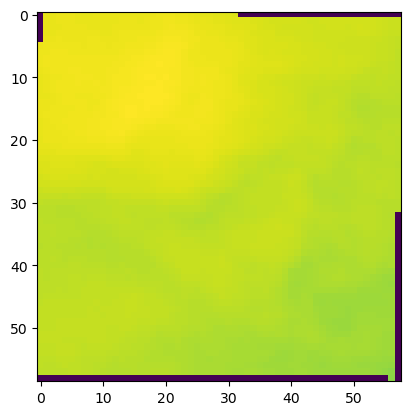

In [50]:
import matplotlib.pyplot as plt
plt.imshow(arr)

In [42]:
meta_gdf.shape

(457, 28)

In [45]:
s3_links[0]

's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2023/015/033/LC09_L2SP_015033_20230324_20230326_02_T2/LC09_L2SP_015033_20230324_20230326_02_T2_SR_B1.TIF'

In [44]:
meta_gdf.head()

,geometry,datetime,eo:cloud_cover,view:sun_azimuth,view:sun_elevation,platform,instruments,view:off_nadir,landsat:cloud_cover_land,landsat:wrs_type,...,proj:transform,created,updated,accuracy:geometric_x_bias,accuracy:geometric_y_bias,accuracy:geometric_x_stddev,accuracy:geometric_y_stddev,accuracy:geometric_rmse,card4l:specification,card4l:specification_version
0,"POLYGON ((-77.69677 39.95094, -78.19886 38.232...",2023-03-24T15:46:30.795494Z,100.00,146.528227,47.590785,LANDSAT_9,"[OLI, TIRS]",0,100.00,2,...,"[30, 0, 217485, 0, -30, 4426515]",2023-03-26T04:42:10.810Z,2023-03-26T04:42:10.810Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-77.69756 39.95336, -78.19997 38.234...",2023-03-16T15:46:23.913000Z,1.22,147.657290,44.467545,LANDSAT_8,"[OLI, TIRS]",0,1.41,2,...,"[30, 0, 218085, 0, -30, 4426815]",2023-03-24T15:13:16.941Z,2023-03-24T15:13:16.941Z,0.0,0.0,3.969,4.384,5.914,SR,5.0
2,"POLYGON ((-77.68658 39.95091, -78.18925 38.232...",2023-03-08T15:46:36.170882Z,0.06,148.827164,41.402740,LANDSAT_9,"[OLI, TIRS]",0,0.07,2,...,"[30, 0, 218385, 0, -30, 4426515]",2023-03-10T05:41:42.811Z,2023-03-10T05:41:42.811Z,0.0,0.0,4.086,4.589,6.144,SR,5.0
3,"POLYGON ((-76.78322 39.88914, -77.23984 38.283...",2023-03-04T13:46:30.932468Z,24.00,120.856098,23.799714,LANDSAT_7,[ETM],0,26.00,2,...,"[30, 0, 297585, 0, -30, 4418415]",2023-03-30T20:41:11.909Z,2023-03-30T20:41:11.909Z,0.0,0.0,3.395,9.180,9.788,SR,5.0
4,"POLYGON ((-77.68633 39.95335, -78.18900 38.234...",2023-02-28T15:46:30.544394Z,90.43,149.890056,38.399303,LANDSAT_8,"[OLI, TIRS]",0,91.81,2,...,"[30, 0, 218985, 0, -30, 4426815]",2023-03-15T22:12:02.018Z,2023-03-15T22:12:02.018Z,0.0,0.0,5.175,5.684,7.687,SR,5.0


In [43]:
s3_links[0]

's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2023/015/033/LC09_L2SP_015033_20230324_20230326_02_T2/LC09_L2SP_015033_20230324_20230326_02_T2_SR_B1.TIF'

In [41]:
s3_links.__len__()

4570

In [33]:
da.rio.clip([geom])

<xarray.DataArray (y: 59, x: 58)>
dask.array<astype, shape=(59, 58), dtype=uint16, chunksize=(59, 58), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3.614e+05 3.615e+05 ... 3.631e+05 3.632e+05
  * y            (y) float64 4.351e+06 4.351e+06 ... 4.349e+06 4.349e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

In [12]:
item = items[0]

32618

In [11]:
da.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [9]:
#da.hvplot(x='x', y='y', crs='epsg:32617', rasterize=True, width=800, height=600, tiles = 'ESRI') # TODO: how to exclude fill values
da.hvplot(x='x', y='y', crs='epsg:32617', rasterize=True, width=800, height=600)

ImportError: Geographic projection support requires geoviews, pyproj and cartopy.

In [ ]:
rio_env = rio.Env(
    AWSSession(session, requester_pays=True,),
#     AWS_NO_SIGN_REQUEST="NO",
#     GDAL_DISABLE_READDIR_ON_OPEN="TRUE",
#                   GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
#                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('cookies.txt'),
#                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('cookies.txt')
                 )
rio_env.__enter__()

In [ ]:
# with rio.Env(AWSSession(session, requester_pays=True,)):
#     with rio.open(s3_links[0]) as src:
#         profile = src.profile
#         arr = src.read()

In [ ]:
hls_da = rioxarray.open_rasterio(s3_links[0], chuncks=True)
hls_da

In [ ]:
hls_da.hvplot.image(x='x', y='y', cmap='fire', rasterize=True, width=800, height=600, colorbar=True)    # colormaps -> https://holoviews.org/user_guide/Colormaps.html

In [ ]:
s3_cred_endpoint = 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'

In [ ]:
def get_temp_creds(username, password):
    temp_creds_url = s3_cred_endpoint
    return requests.get(temp_creds_url, auth=(username, password)).json()

In [ ]:
# temp_creds = get_temp_creds(NASA_EARTHDATA_USERNAME, NASA_EARTHDATA_PASSWORD)

In [ ]:
r = requests.get(s3_cred_endpoint)

In [ ]:
r.content

In [ ]:
temp_creds_req = get_temp_creds()

In [ ]:
datetime_range = "2014-01-01T00:00:00Z/2023-02-28T00:00:00Z"

In [ ]:
s3_link = s3_links[0]

In [ ]:
session = boto3.Session(aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY)

In [ ]:
rio_env = rio.Env(AWSSession(session, requester_pays=True), 
                  AWS_NO_SIGN_REQUEST='NO',
                  GDAL_DISABLE_READDIR_ON_OPEN='TRUE')
rio_env.__enter__()

In [ ]:
http_links[0]

In [ ]:
s3_link

In [ ]:
da = rioxarray.open_rasterio(s3_link, chunks="auto").squeeze("band", drop=True)

In [ ]:
da.rio.clip()

In [ ]:
da.hvplot(x="x", y="y", rasterize=True, width=800, height=800)

In [ ]:
rio

In [ ]:
arr = stack.to_numpy()

In [ ]:
href = items[0].get_assets()["blue"].get_absolute_href()


In [ ]:
stack.attrs["transform"] = stack.attrs["transform"].to_gdal()
stack.attrs["spec"] = stack.attrs["spec"].vrt_params

In [ ]:
blue = items[0].assets["blue"]

In [ ]:
with open("tmp.tif", "wb") as f:
    f.write(blue)

In [ ]:
import requests

In [ ]:
login_response = requests.post(f"{url}/login", auth=(username, password)).json()
login_response

In [ ]:
from requests.auth import HTTPBasicAuth
# login_
headers = dict(Accept="application/json")
auth = HTTPBasicAuth(username, password)
r = requests.get(blue.href, headers=headers, auth=auth)
r

In [ ]:
r.content

In [ ]:
blue.href

In [ ]:
r.content

In [ ]:
r.content

In [ ]:

blue.href

In [ ]:
blue.href

In [ ]:
import rasterio as rio
with rio.open(items[0].assets["blue"].href) as rast:
    arr = rast.read()
    profile = rast.profile

In [ ]:
stack

In [ ]:
for k, v in stack.attrs.items():
    print(k, type(v))

In [ ]:
stack.to_netcdf(ds_dst)

In [ ]:
stack.to_netcdf()

In [ ]:

ds = stack.to_dataset()

In [ ]:
transform = stack.attrs["transform"]
transform

In [ ]:
attrs = ds.attrs.copy()

In [ ]:

attrs["transform"] = attrs["transform"].to_gdal()

In [ ]:
attrs

In [ ]:

ds.to_netcdf(ds_dst)

In [ ]:
write_dataset_to_netcdf(ds, ds_dst)

In [ ]:
import datacube
dc = datacube.Datacube()

In [ ]:
datacube.drivers.

In [ ]:
items[0]

In [ ]:
len(items)

In [ ]:
search.item_collection()

In [ ]:
ds = rioxarray.open_rasterio(
    
)

In [ ]:
requests.head(items[0].assets["blue"].href).status_code

In [ ]:
import rioxarray

In [ ]:
gdf = gpd.read_file(geojson_src).set_crs(4326)
# lon, lat = get_lon_lat_from_gdf(gdf)
# epsg = find_epsg_from_lon_lat(lon, lat)
# gdf = gdf.to_crs(epsg)

In [ ]:
client = Client.open(url)
search = client.search(
    collections=['landsat-c2l2-sr'],
    bbox=gdf.to_crs(4326).bounds.loc[0].values.tolist(),
    datetime="2018-01-01/2018-01-31",
)
items = search.item_collection()
epsg = items[0].properties["proj:epsg"]
print(len(items))

In [ ]:
geopoly = Geometry(json.loads(gdf.to_crs(epsg).to_json())["features"][0]["geometry"])
geopoly.crs = CRS(epsg)
geobox = GeoBox.from_geopolygon(geopoly, (res, res))
geobox

In [ ]:
in_proj = Proj("epsg:4326")

In [ ]:
crs = item.properties["proj:epsg"]
out_proj = Proj(f"epsg:{crs}")

In [ ]:
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{crs}")
x1, y1 = transformer.transform(bbox[0], bbox[1])
x2, y2 = transformer.transform(bbox[2], bbox[3])

In [ ]:
minx, miny, maxx, maxy  = gdf.to_crs(epsg).bounds.loc[0].tolist()

In [ ]:
ds = stac_load(
    items,
    bbox=(minx, miny, maxx, maxy),
#     geobox=geobox,
    bands=["red"],
    groupby="solar_day",
    resolution=30,
    crs=epsg
)

In [ ]:
from requests.auth import HTTPBasicAuth
item = items[0]
method = "get"
crs = item.properties["proj:epsg"]
href = item.assets["red"].href
auth = HTTPBasicAuth(USGS_TOKEN)
r = requests.request(method, href, headers=None, auth=auth)

In [ ]:
xx = stac_load(
    query.items(),
    groupby="solar_day",
    crs=crs,
)

In [ ]:
item = items[-1]

In [ ]:
item.datetime

In [ ]:
items[0].datetime

In [ ]:
items[0].datetime

In [ ]:
xx = odc.stac.load(
    
)

In [ ]:
item = items[0]

In [ ]:
import odc

In [ ]:
type(items)

In [ ]:
# Don't run -takes forever
for item in my_search.items():
    for asset in item.assets.values():
        resp = request.urlretrieve(asset.href, path.basename(asset.href))